In [1]:
# read jsonl

import json

In [2]:
from datasets import load_dataset

/mbz/users/shibo.hao/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from verl.utils.reward_score.prime_math import compute_score
# from verl.workers.reward_manager import PrimeRewardManager

2025-03-12 22:28:26,333	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

In [5]:

data = []
for node_id in range(64):
    for chunk_id in range(4):
        with open(f'../sgl_inference_results/big-math-rl-verified_problems/node_{node_id}/batch_results_chunk_{chunk_id}.jsonl', 'r') as f:
            for id, line in enumerate(f):
                if id >= 64:
                    break
                data.append(json.loads(line))


In [ ]:
d_ = [(int(d['custom_id'].split('-')[1]), d['response']['body']['choices']['message']['content']) for d in data]

In [ ]:
saved_data

In [11]:
from tqdm import tqdm
saved_data = {}
for d in tqdm(d_):
    if d[0] not in saved_data:
        saved_data[d[0]] = {
            "question": dataset['problem'][d[0]],
            "answer": dataset['answer'][d[0]],
            "model_outputs": [d[1]]
        }
    else:
        saved_data[d[0]]['model_outputs'].append(d[1])

100%|██████████| 16384/16384 [02:25<00:00, 112.71it/s]


In [ ]:
saved_data[0]

In [9]:
dataset = load_dataset("SynthLabsAI/Big-Math-RL-Verified",
                       trust_remote_code=True,
                       split='train')

In [13]:
dataset['problem'][103]

'In the sequence $\\{a_n\\}$, $a_{n+1}= \\frac {a_n}{1+3a_n}$, $a_1=2$, then $a_{10}=$ ______.'

In [15]:
dataset['source'][103]

'cn_k12'

In [23]:
answers = dataset["answer"]

In [20]:
from tqdm import tqdm

In [21]:
# import match_answer
from verl.utils.reward_score.prime_math import match_answer

In [24]:
result_dict = {}

stats = {}

for d in tqdm(data):
    response = d['response']['body']['choices']['message']['content']
    id = d['custom_id']
    question_id = int(id.split("-")[1])
    sample_id = int(id.split("-")[-1])
    if question_id not in stats:
        stats[question_id] = (0, 0)
    
    correct = compute_score(response, answers[question_id])[0]
    stats[question_id] = (stats[question_id][0] + correct, stats[question_id][1] + 1)
    matched, model_output = match_answer(response)
    d['matched'] = matched
    d['model_output'] = model_output
    d['correct'] = correct
    result_dict[f"{question_id}-{sample_id}"] = {
        "matched": matched,
        "model_output": model_output,
        "correct": correct
    }
    

100%|██████████| 32768/32768 [00:28<00:00, 1135.89it/s]


In [27]:
from verl.utils.reward_score.prime_math import grade_answer

In [31]:
stats

{0: (9, 32),
 1: (32, 32),
 2: (32, 32),
 3: (8, 32),
 4: (21, 32),
 5: (20, 32),
 6: (32, 32),
 7: (24, 32),
 8: (29, 32),
 9: (32, 32),
 10: (18, 32),
 11: (32, 32),
 12: (30, 32),
 13: (32, 32),
 14: (0, 32),
 15: (32, 32),
 16: (0, 32),
 17: (32, 32),
 18: (0, 32),
 19: (29, 32),
 20: (31, 32),
 21: (32, 32),
 22: (31, 32),
 23: (0, 32),
 24: (17, 32),
 25: (32, 32),
 26: (0, 32),
 27: (15, 32),
 28: (16, 32),
 29: (25, 32),
 30: (31, 32),
 31: (18, 32),
 32: (32, 32),
 33: (32, 32),
 34: (32, 32),
 35: (17, 32),
 36: (32, 32),
 37: (32, 32),
 38: (7, 32),
 39: (30, 32),
 40: (0, 32),
 41: (32, 32),
 42: (32, 32),
 43: (32, 32),
 44: (30, 32),
 45: (0, 32),
 46: (31, 32),
 47: (32, 32),
 48: (29, 32),
 49: (0, 32),
 50: (0, 32),
 51: (13, 32),
 52: (0, 32),
 53: (32, 32),
 54: (32, 32),
 55: (32, 32),
 56: (0, 32),
 57: (32, 32),
 58: (0, 32),
 59: (32, 32),
 60: (28, 32),
 61: (31, 32),
 62: (30, 32),
 63: (0, 32),
 64: (30, 32),
 65: (32, 32),
 66: (5, 32),
 67: (0, 32),
 68: (0,

In [33]:
model_outputs

['2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2']

In [35]:
# get the majority voting answer and calculate the accuracy
final_answers = []
for question_id in stats:
    model_outputs = [result_dict[f"{question_id}-{j}"]["model_output"] for j in range(32)]
    final_answers.append(max(set(model_outputs), key=model_outputs.count))

# calculate the accuracy
accuracy = sum([1 for i in range(len(final_answers)) if grade_answer(final_answers[i], answers[i])]) / len(final_answers)
print(accuracy)


0.69921875


In [41]:
response = "\\boxed{\{4, 5, 6, 7, 8\}}"

<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_143522/2384316447.py:1: SyntaxWarning: invalid escape sequence '\{'
  response = "\\boxed{\{4, 5, 6, 7, 8\}}"


In [51]:
print("\\")

\


In [70]:
print("\\boxed{\\ 4, 5, 6, 7, 8}")

\boxed{\ 4, 5, 6, 7, 8}


In [88]:
x = "\{4, 5, 6, 7, 8\}"

<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_143522/34990606.py:1: SyntaxWarning: invalid escape sequence '\{'
  x = "\{4, 5, 6, 7, 8\}"


In [78]:
print(dataset['answer'][524])

{4, 5, 6, 7, 8}


In [29]:
len(stats)

1024

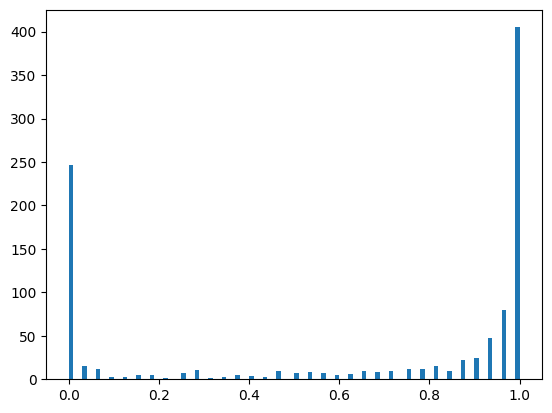

In [30]:
# draw a hist of the stats
import matplotlib.pyplot as plt
plt.hist([i[0]/i[1] for i in stats.values()], bins=100)
plt.show()


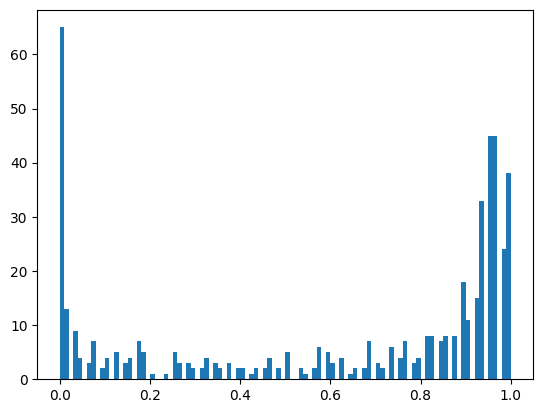

In [13]:
# draw a hist of the stats
import matplotlib.pyplot as plt
plt.hist([i[0]/i[1] for i in stats.values()], bins=100)
plt.show()


In [36]:
# find out the question id with the highest accuracy
max_accuracy = max([i[0]/i[1] for i in stats.values()])
max_question_ids = [k for k, v in stats.items() if v[0]/v[1] == max_accuracy]
# show first 10 questions
for i in range(10):
    print(dataset["problem"][max_question_ids[i]])
    print(answers[max_question_ids[i]])
    print("-"*100)


In acute triangle $\triangle ABC$, the sides opposite to angles $A$, $B$, and $C$ are $a$, $b$, and $c$, respectively. If $a=4$, $b=5$, and the area of $\triangle ABC$ is $5 \sqrt {3}$, find $|AB|$.
\\sqrt{21}
----------------------------------------------------------------------------------------------------
If the linear function is $y=2x-3$, and it is shifted $3$ units upwards, the new equation of the graph is ______.
y = 2x
----------------------------------------------------------------------------------------------------
If $\left(3x-y+5\right)^{2}+|2x-y+3|=0$, then $x+y=\_\_\_\_\_\_$.
-3
----------------------------------------------------------------------------------------------------
Simplify first, then evaluate: $3(a^{2}-ab+7)-2(3ab-a^{2}+1)+3$, where $a=2$ and $b=\frac{1}{3}$.
36
----------------------------------------------------------------------------------------------------
The line $y=kx-2$ intersects the parabola $y^2=8x$ at points A and B, and the x-coordinate of t

In [37]:
# average accuracy

print(sum([i[0]/i[1] for i in stats.values()])/len(stats))

0.6483154296875


In [38]:
result_dict

{'0-0': {'matched': True, 'model_output': '0.5', 'correct': False},
 '0-1': {'matched': True,
  'model_output': '\\left[0, \\frac{1}{2}\\right]',
  'correct': True},
 '0-2': {'matched': True,
  'model_output': '\\left[0, \\frac{1}{2}\\right]',
  'correct': True},
 '0-3': {'matched': False,
  'model_output': '(-\\infty, \\infty)',
  'correct': False},
 '0-4': {'matched': False, 'model_output': '\\emptyset', 'correct': False},
 '0-5': {'matched': True,
  'model_output': '\\left( \\frac{1}{2}, 1 \\right)',
  'correct': False},
 '0-6': {'matched': True,
  'model_output': '\\left(0, \\frac{1}{2}\\right)',
  'correct': False},
 '0-7': {'matched': True, 'model_output': '[0.5, 1]', 'correct': False},
 '0-8': {'matched': True,
  'model_output': '\\left[0, \\dfrac{1}{2}\\right]',
  'correct': True},
 '0-9': {'matched': True, 'model_output': '[0, 1]', 'correct': False},
 '0-10': {'matched': True,
  'model_output': '\\left[ \\frac{1}{2}, 1 \\right]',
  'correct': False},
 '0-11': {'matched': False

In [42]:
x = 0

# lowest accuracy
min_accuracy = min([i[0]/i[1] for i in stats.values()])
min_question_ids = [k for k, v in stats.items() if v[0]/v[1] == min_accuracy]
print(min_question_ids)
# show first 10 questions
for i in range(len(min_question_ids)):
    # print(dataset["problem"][min_question_ids[i]])
    # print(answers[min_question_ids[i]])
    # show the most frequent model output
    model_outputs = [result_dict[f"{min_question_ids[i]}-{j}"]["model_output"] for j in range(32)]
    most_frequent_model_output = max(set(model_outputs), key=model_outputs.count)
    # print(most_frequent_model_output, model_outputs.count(most_frequent_model_output))
    # print("-"*100)
    count = model_outputs.count(most_frequent_model_output)
    if count > 54:
        print("question: ", dataset["problem"][min_question_ids[i]])
        print("reference answer: ", answers[min_question_ids[i]])
        print("most frequent model output: ", most_frequent_model_output)
        print("count: ", count)
        # other model outputs and count
        other_model_outputs = [i for i in model_outputs if i != most_frequent_model_output]
        print("other model outputs: ", other_model_outputs)
        print("other model outputs count: ", len(other_model_outputs))
        
        print("-"*100)
        x += 1

[14, 16, 18, 23, 26, 40, 45, 49, 50, 52, 56, 58, 63, 67, 68, 75, 85, 87, 91, 97, 106, 107, 111, 121, 123, 128, 131, 134, 148, 152, 154, 169, 171, 179, 180, 187, 190, 193, 195, 196, 199, 204, 208, 210, 211, 213, 214, 219, 220, 222, 224, 233, 239, 240, 246, 252, 260, 264, 271, 273, 277, 280, 282, 287, 288, 291, 304, 307, 308, 310, 313, 314, 321, 322, 327, 336, 341, 344, 361, 364, 377, 381, 382, 386, 387, 390, 394, 397, 399, 403, 409, 425, 426, 427, 431, 432, 434, 438, 443, 444, 454, 455, 457, 465, 468, 472, 473, 475, 476, 480, 494, 499, 501, 502, 504, 505, 506, 508, 513, 515, 524, 528, 529, 533, 535, 536, 538, 539, 540, 542, 547, 549, 554, 560, 565, 568, 575, 580, 595, 598, 603, 610, 612, 615, 618, 619, 620, 629, 631, 637, 639, 645, 646, 647, 653, 655, 665, 667, 672, 673, 675, 680, 684, 696, 701, 706, 716, 720, 721, 722, 728, 729, 730, 732, 738, 740, 744, 746, 748, 753, 754, 756, 758, 760, 764, 766, 768, 771, 778, 784, 786, 787, 789, 798, 807, 817, 821, 823, 829, 832, 833, 838, 839, 849,

In [31]:
x

18

In [47]:
x = 0

# lowest accuracy
min_accuracy = min([i[0]/i[1] for i in stats.values()])
min_question_ids = [k for k, v in stats.items() if v[0]/v[1] < 0.1 and v[0]/v[1] > 0.01]
# show first 10 questions
for i in range(len(min_question_ids)):
    # print(dataset["problem"][min_question_ids[i]])
    # print(answers[min_question_ids[i]])
    # show the most frequent model output
    model_outputs = [result_dict[f"{min_question_ids[i]}-{j}"]["model_output"] for j in range(32)]
    most_frequent_model_output = max(set(model_outputs), key=model_outputs.count)
    # print(most_frequent_model_output, model_outputs.count(most_frequent_model_output))
    # print("-"*100)
    count = model_outputs.count(most_frequent_model_output)
    if count > 16:
        print("question: ", dataset["problem"][min_question_ids[i]])
        print("reference answer: ", answers[min_question_ids[i]])
        print("most frequent model output: ", most_frequent_model_output)
        print("count: ", count)
        # other model outputs and count
        other_model_outputs = [i for i in model_outputs if i != most_frequent_model_output]
        print("other model outputs: ", other_model_outputs)
        print("other model outputs count: ", len(other_model_outputs))
        
        print("-"*100)
        x += 1

question:  Compare the following numbers: $-\sqrt{10}$____$-3$.
reference answer:  <
most frequent model output:  -\sqrt{10} < -3
count:  24
other model outputs:  ['-3 > -\\sqrt{10}', '-3', '<', '<', '-\\sqrt{10} > -3', '-\\sqrt{10} > -3', '-\\sqrt{10} > -3', '-\\sqrt{10} > -3']
other model outputs count:  8
----------------------------------------------------------------------------------------------------
question:  The graph of the function $f(x)$ is translated 1 unit to the right, and the resulting graph is symmetric to the curve $y=e^x$ with respect to the y-axis. Then, $f(x)=$ ______.
reference answer:  e^{-(x+1)}
most frequent model output:  e^{-x - 1}
count:  29
other model outputs:  ['e^{-x-1}', 'e^{-(x + 1)}', 'e^{-(x + 1)}']
other model outputs count:  3
----------------------------------------------------------------------------------------------------
question:  Solve the inequality system: $\left\{\begin{array}{l}{2x+1>x+3①}\\{2x-4<x②}\end{array}\right.$.
reference answer

In [48]:
x

18

In [37]:
print(dataset['solution'][519])

1. **Identify the prime factorization of 100,000**: 
   The prime factorization of $100,000$ is $100,000 = 10^5 = (2 \cdot 5)^5 = 2^5 \cdot 5^5$.

2. **Determine the set $S$ of divisors**:
   The set $S$ consists of all divisors of $100,000$, which can be expressed in the form $2^a5^b$ where $0 \leq a, b \leq 5$.

3. **Consider the product of two distinct elements of $S$**:
   Let's consider two distinct elements $2^a5^b$ and $2^c5^d$ from $S$. Their product is $2^{a+c}5^{b+d}$. We need to ensure $(a, b) \neq (c, d)$.

4. **Range of exponents in the product**:
   Since $0 \leq a, c \leq 5$ and $0 \leq b, d \leq 5$, the sums $a+c$ and $b+d$ can range from $0$ to $10$. Thus, the product can be any divisor of $2^{10}5^{10}$.

5. **Counting divisors of $2^{10}5^{10}$**:
   The number $2^{10}5^{10}$ has $(10+1)(10+1) = 121$ divisors, as each exponent can independently range from $0$ to $10$.

6. **Exclude non-distinct products**:
   We need to exclude products that cannot be formed by the m

In [51]:
dataset['llama8b_solve_rate']

[0.125,
 0.359375,
 0.53125,
 0.78125,
 0.0,
 0.109375,
 0.234375,
 0.0,
 0.40625,
 0.34375,
 0.109375,
 0.3125,
 0.234375,
 0.125,
 0.296875,
 0.703125,
 0.484375,
 1.0,
 0.375,
 0.015625,
 0.109375,
 0.359375,
 0.71875,
 0.203125,
 0.84375,
 0.734375,
 0.328125,
 0.140625,
 0.4375,
 0.046875,
 0.0,
 0.125,
 0.671875,
 0.515625,
 0.765625,
 0.046875,
 0.3125,
 0.21875,
 0.015625,
 0.421875,
 0.015625,
 0.84375,
 0.171875,
 0.828125,
 0.34375,
 0.359375,
 0.296875,
 0.765625,
 0.46875,
 0.046875,
 0.09375,
 0.328125,
 0.6875,
 0.78125,
 0.203125,
 0.421875,
 0.46875,
 0.015625,
 0.609375,
 0.359375,
 0.3125,
 0.046875,
 0.28125,
 0.015625,
 0.0,
 1.0,
 0.140625,
 0.4375,
 0.09375,
 0.875,
 0.703125,
 1.0,
 0.703125,
 1.0,
 0.0,
 0.84375,
 0.03125,
 0.21875,
 0.703125,
 0.84375,
 0.046875,
 0.046875,
 0.28125,
 0.125,
 0.0625,
 0.421875,
 0.1875,
 0.484375,
 0.03125,
 0.234375,
 1.0,
 0.28125,
 0.015625,
 0.015625,
 0.640625,
 0.015625,
 0.578125,
 0.0,
 0.03125,
 0.875,
 0.359375,
 0.0

In [52]:
# get the ones which llama3-8b solve well but our model output is not correct

for i in range(len(dataset)):
    if dataset['llama8b_solve_rate'][i] > 0.8 and dataset['answer'][i] != 

KeyError: "Column solution not in the dataset. Current columns in the dataset: ['problem', 'answer', 'source', 'domain', 'llama8b_solve_rate']"